<a href="https://colab.research.google.com/github/Mohamed-Adel-l/Deep-Learning/blob/main/Rock%2CPaper%2CScissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers
import pandas as pd

In [ ]:
(train_full, test), info = tfd.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock

In [ ]:
IMG_size=300
train_full = tfd.load('rock_paper_scissors', split='train[:90%]', as_supervised=True)     #split into training and validation
val_full = tfd.load('rock_paper_scissors', split='train[90%:]', as_supervised=True)
def preprocessing(img, label):
   print(f"{img.shape}")
   image=tf.image.resize(img, (IMG_size, IMG_size))
   image=tf.cast(image, tf.float32)/255.0
   return image, label
train = train_full.map(preprocessing).cache().shuffle(1000).batch(32)     #Preprocess the training dataset
val = val_full.map(preprocessing).cache().batch(32)
test = test.map(preprocessing).cache().batch(32)
print(f"training dataset batch size: {train_full.cardinality()}")
print(f"Validation dataset batch size: {val.cardinality()}")

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
training dataset batch size: 2268
Validation dataset batch size: 8


In [ ]:
optimizer_list={
    'sgd':optimizers.SGD(learning_rate=0.01),
    'momentum':optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'nesterov':optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    'adagrad':optimizers.Adagrad(learning_rate=0.01),
    'rmsprop':optimizers.RMSprop(learning_rate=0.001),
    'adam':optimizers.Adam(learning_rate=0.001),
}

In [ ]:
def mlp(optimizer):           #MLP
  model=models.Sequential([
    layers.Input(shape=(IMG_size,IMG_size,3,)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])
  model.compile(optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])
  return model


In [ ]:
history_mlp={}
best_model=None
best_optimizer=""
best_acc=0
for name,opt in optimizer_list.items():
  print(f"{name} training")
  model=mlp(opt)
  hist= model.fit(train, validation_data=val, epochs=5, verbose=1)
  history_mlp[name]=hist.history
  current_mode_acc=max(hist.history['val_acc'])
  if best_model is None or current_mode_acc>best_acc:
    best_model=model
    best_acc=current_mode_acc
    best_optimizer=name
print(f"Best optimizer:{best_optimizer}")

sgd training
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - acc: 0.3317 - loss: 137.0697 - val_acc: 0.3333 - val_loss: 1.0988
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.3255 - loss: 1.0993 - val_acc: 0.3333 - val_loss: 1.0987
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.3448 - loss: 1.0985 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.3177 - loss: 1.0988 - val_acc: 0.3333 - val_loss: 1.0986
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.3212 - loss: 1.0988 - val_acc: 0.3333 - val_loss: 1.0986
momentum training
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - acc: 0.3486 - loss: 87.1829 - val_acc: 0.3333 - val_loss: 1.1218
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - acc: 0.3335 - loss: 1.0999 - val_acc: 0.3333 - val_loss: 1.0988
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.3176 - loss: 1.0997 - val_acc: 0.3333 - val_loss: 1.0988
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
for name, hist in history_mlp.items():
    print("=" * 50)
    for epoch in range(len(hist['loss'])):
        training_loss = hist['loss'][epoch]
        training_acc = hist['acc'][epoch]
        val_loss = hist['val_loss'][epoch]
        val_acc = hist['val_acc'][epoch]

        print(f"Epoch {epoch+1}:")
        print(f"  🔹 Training Loss: {training_loss:.4f}")
        print(f"  🔹 Training Accuracy: {training_acc:.4f}")
        print(f"  🔸 Validation Loss: {val_loss:.4f}")
        print(f"  🔸 Validation Accuracy: {val_acc:.4f}")

Epoch 1:
  🔹 Training Loss: 50.3902
  🔹 Training Accuracy: 0.3219
  🔸 Validation Loss: 1.0988
  🔸 Validation Accuracy: 0.3333
Epoch 2:
  🔹 Training Loss: 1.0989
  🔹 Training Accuracy: 0.3333
  🔸 Validation Loss: 1.0987
  🔸 Validation Accuracy: 0.3333
Epoch 3:
  🔹 Training Loss: 1.0988
  🔹 Training Accuracy: 0.3333
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 4:
  🔹 Training Loss: 1.0987
  🔹 Training Accuracy: 0.3263
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 5:
  🔹 Training Loss: 1.0987
  🔹 Training Accuracy: 0.3333
  🔸 Validation Loss: 1.0986
  🔸 Validation Accuracy: 0.3333
Epoch 1:
  🔹 Training Loss: 37.9725
  🔹 Training Accuracy: 0.3422
  🔸 Validation Loss: 1.1218
  🔸 Validation Accuracy: 0.3333
Epoch 2:
  🔹 Training Loss: 1.0998
  🔹 Training Accuracy: 0.3254
  🔸 Validation Loss: 1.0988
  🔸 Validation Accuracy: 0.3333
Epoch 3:
  🔹 Training Loss: 1.0997
  🔹 Training Accuracy: 0.3192
  🔸 Validation Loss: 1.0988
  🔸 Validation Accuracy: 0.333

In [ ]:
test_loss, test_acc=best_model.evaluate(test)
print(f"Test loss:{test_loss}\nTest accuracy:{test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - acc: 0.6183 - loss: 7.1924
Test loss:7.530817985534668
Test accuracy:0.5994623899459839


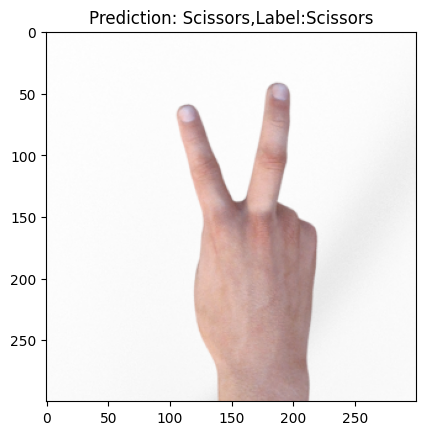

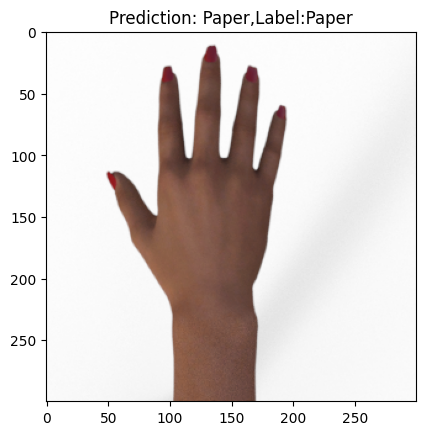

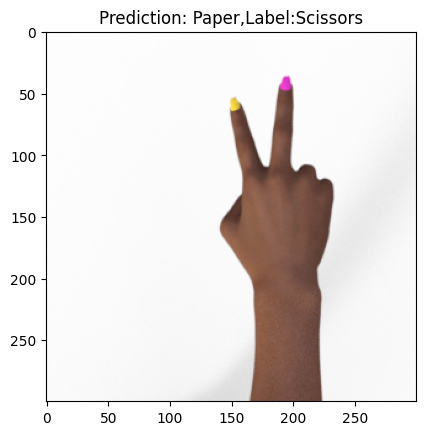

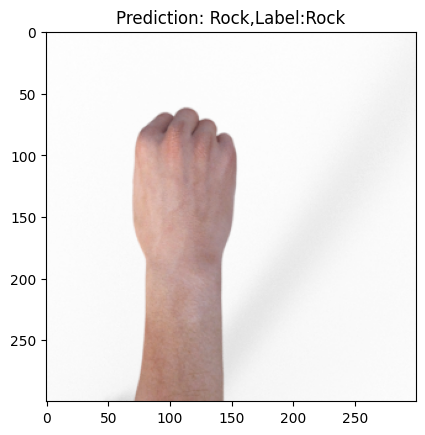

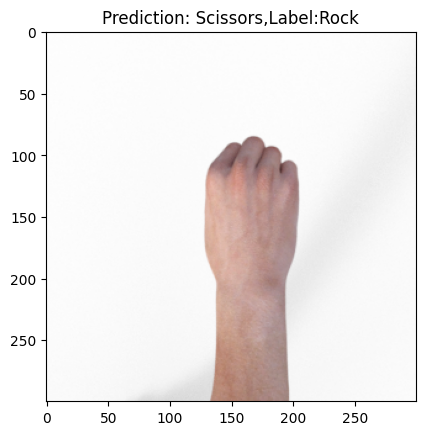

In [ ]:
class_label=['Rock','Paper','Scissors']
for image,label in test.unbatch().take(5):
  img=image.numpy()
  label=label.numpy()
  img_reshaped=tf.expand_dims(image, 0)
  prediction=model.predict(img_reshaped,verbose=0)
  prediction_label=np.argmax(prediction)
  plt.imshow(img)
  plt.title(f"Prediction: {class_label[prediction_label]},Label:{class_label[label]}")
  plt.show()

In [ ]:
def cnn(optimizer):           #CNN
  model=models.Sequential([
    layers.Input(shape=(IMG_size,IMG_size,3,)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])
  model.compile(optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['acc'])
  return model

In [ ]:
history_cnn = {}
for name, optimizer in optimizer_list.items():
    print(f"Training with {name}")
    model = cnn(optimizer)
    hist = model.fit(train, validation_data=val, epochs=5, verbose=1)
    history_cnn[name] = hist.history

    current_val_acc = max(hist.history.get('val_accuracy', hist.history.get('val_acc')))



Training with sgd
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - acc: 0.3823 - loss: 1.0901 - val_acc: 0.4286 - val_loss: 1.0414
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - acc: 0.5125 - loss: 1.0198 - val_acc: 0.5754 - val_loss: 0.9074
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - acc: 0.5624 - loss: 0.9094 - val_acc: 0.7976 - val_loss: 0.7538
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - acc: 0.7170 - loss: 0.7450 - val_acc: 0.4524 - val_loss: 0.9073
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - acc: 0.7835 - loss: 0.6239 - val_acc: 0.9603 - val_loss: 0.2043
Training with momentum
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - acc: 0.3734 - loss: 1.0976 - val_acc: 0.5119 - val_loss: 1.0333
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - acc: 0.5985 - loss: 0.9028 - val_acc: 0.9325 - val_loss: 0.1923
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - acc: 0.9794 - loss: 0.0662 - val_acc: 1.0000 - val_loss: 0.0019
Epoch 4/5
71/71 ━━━━━━━━━━━

In [ ]:
for name, hist in history_cnn.items():
    print("=" * 50)
    for epoch in range(len(hist['loss'])):
        training_loss = hist['loss'][epoch]
        training_acc = hist['acc'][epoch]
        val_loss = hist['val_loss'][epoch]
        val_acc = hist['val_acc'][epoch]

        print(f"Epoch {epoch+1}:")
        print(f"  🔹 Training Loss: {training_loss:.4f}")
        print(f"  🔹 Training Accuracy: {training_acc:.4f}")
        print(f"  🔸 Validation Loss: {val_loss:.4f}")
        print(f"  🔸 Validation Accuracy: {val_acc:.4f}")

Epoch 1:
  🔹 Training Loss: 1.0774
  🔹 Training Accuracy: 0.4087
  🔸 Validation Loss: 1.0414
  🔸 Validation Accuracy: 0.4286
Epoch 2:
  🔹 Training Loss: 0.9935
  🔹 Training Accuracy: 0.5344
  🔸 Validation Loss: 0.9074
  🔸 Validation Accuracy: 0.5754
Epoch 3:
  🔹 Training Loss: 0.8714
  🔹 Training Accuracy: 0.6124
  🔸 Validation Loss: 0.7538
  🔸 Validation Accuracy: 0.7976
Epoch 4:
  🔹 Training Loss: 0.6957
  🔹 Training Accuracy: 0.7227
  🔸 Validation Loss: 0.9073
  🔸 Validation Accuracy: 0.4524
Epoch 5:
  🔹 Training Loss: 0.4853
  🔹 Training Accuracy: 0.8386
  🔸 Validation Loss: 0.2043
  🔸 Validation Accuracy: 0.9603
Epoch 1:
  🔹 Training Loss: 1.0817
  🔹 Training Accuracy: 0.4233
  🔸 Validation Loss: 1.0333
  🔸 Validation Accuracy: 0.5119
Epoch 2:
  🔹 Training Loss: 0.6545
  🔹 Training Accuracy: 0.7231
  🔸 Validation Loss: 0.1923
  🔸 Validation Accuracy: 0.9325
Epoch 3:
  🔹 Training Loss: 0.0386
  🔹 Training Accuracy: 0.9881
  🔸 Validation Loss: 0.0019
  🔸 Validation Accuracy: 1.0000


In [ ]:
row_labels = [
    "MLP Train Loss", "MLP Train Accuracy", "MLP Val Loss", "MLP Val Accuracy",
    "CNN Train Loss", "CNN Train Accuracy", "CNN Val Loss", "CNN Val Accuracy"
]

table_data = {"Metric": row_labels}


for opt in history_mlp.keys():
    mlp_hist = history_mlp[opt]
    cnn_hist = history_cnn[opt]

    mlp_last = len(mlp_hist['loss']) - 1
    cnn_last = len(cnn_hist['loss']) - 1
    table_data[opt.upper()] = [
        round(float(mlp_hist['loss'][mlp_last]), 4),
        round(float(mlp_hist.get('accuracy', mlp_hist.get('acc'))[mlp_last]), 4),
        round(float(mlp_hist['val_loss'][mlp_last]), 4),
        round(float(mlp_hist.get('val_accuracy', mlp_hist.get('val_acc'))[mlp_last]), 4),

        round(float(cnn_hist['loss'][cnn_last]), 4),
        round(float(cnn_hist.get('accuracy', cnn_hist.get('acc'))[cnn_last]), 4),
        round(float(cnn_hist['val_loss'][cnn_last]), 4),
        round(float(cnn_hist.get('val_accuracy', cnn_hist.get('val_acc'))[cnn_last]), 4),
    ]

df = pd.DataFrame(table_data)


numeric_columns = df.columns[1:]
styled_df = df.style.set_caption("Final Evaluation Metrics (MLP vs CNN)") \
                    .set_table_styles([{
                        'selector': 'caption',
                        'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold')]
                    }]) \
                    .format(precision=4, subset=numeric_columns)

styled_df


,Metric,SGD,MOMENTUM,NESTEROV,ADAGRAD,RMSPROP,ADAM
0,MLP Train Loss,1.0987,1.0995,1.0992,1.0719,1.7369,1.6115
1,MLP Train Accuracy,0.3333,0.3285,0.3104,0.4559,0.3686,0.8047
2,MLP Val Loss,1.0986,1.0987,1.0987,0.9271,1.0990,1.6224
3,MLP Val Accuracy,0.3333,0.3333,0.3333,0.5714,0.3333,0.7817
4,CNN Train Loss,0.4853,0.0013,0.0005,0.0177,0.0374,0.0000
5,CNN Train Accuracy,0.8386,0.9996,1.0000,0.9960,0.9903,1.0000
6,CNN Val Loss,0.2043,0.0001,0.0003,0.0084,0.0009,0.0000
7,CNN Val Accuracy,0.9603,1.0000,1.0000,1.0000,1.0000,1.0000
